# Обучение с учителем. Классификация
## Прогнозирование оттока клиентов банка

Некоторый банк хочет разработать кампанию лояльности по удержанию клиентов. Для этого он хочет прогнозировать вероятности оттока клиентов и определять, уйдёт ли клиент в ближайшее время. 

**Задача**: построить классификатор, который позволит своевременно определять уходящих клиентов банка, оценить качество построенных моделей и проинтерпретировать результаты.

План:
1. Разведывательный анализ данных
2. Предобработка данных
3. Выбор метрики
4. Логистическая регрессия
5. Полиномиальная регрессия
6. Деревья решений и случайный лес

Для начала импортируем библиотеки, которые нам понадобятся:

In [1]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные модели
from sklearn import metrics #метрики
from sklearn import model_selection #сплитование выборки
from sklearn import preprocessing #предобработка данных
%matplotlib inline

Итак, прочитаем нашу таблицу:

In [114]:
data = pd.read_csv('data/churn.csv')
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


### 1. Разведывательный анализ данных

In [115]:
print(data.shape) # Размер таблицы

# Выведем информацию о пропусках, так как наличие пропусков не позволит нам построить модель линейной регрессии
display(data.isnull().sum())

# Посмотрим на типы данных
display(data.dtypes)

(10000, 14)


RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

Посмотрим на числовые признаки в разрезе графиков: выбросы, распределения

In [116]:
# удалим неинформативные признаки
data = data.drop(['RowNumber', 'Surname', 'CustomerId'], axis = 1)
data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [117]:
#выделяем имена числовых признаков в виде списка для удобства дальнейшей работы
types = data.dtypes
num_features = list(types[(types != 'object')].index)
num_features

['CreditScore',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary',
 'Exited']

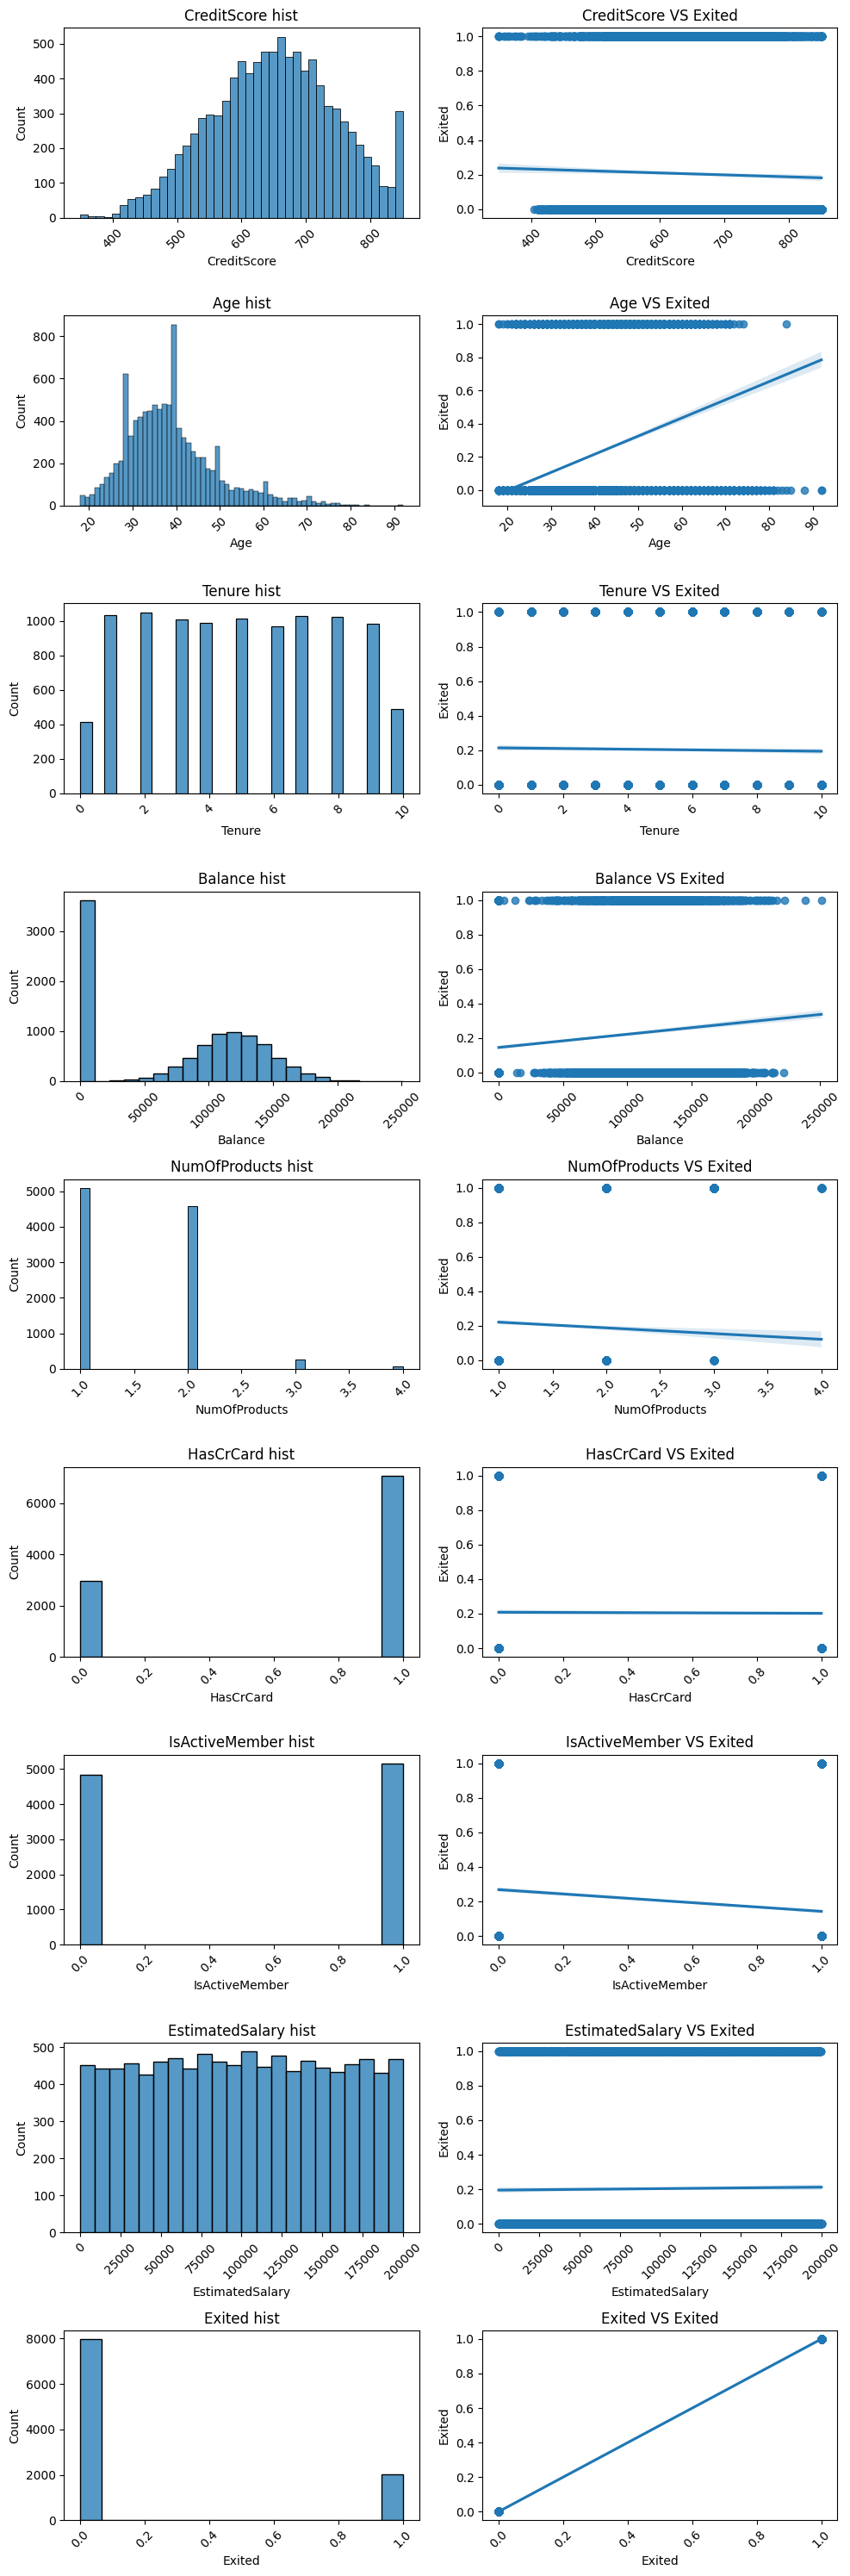

In [118]:
n = len(num_features) #количество признаков
fig, axes = plt.subplots(n, 2, figsize=(10, 30)) # фигура + n х 2 координатных плоскостей
#Создаем цикл для всех признаков из списка числовых признаков

# цИКЛ ЧТОБЫ ПОСТРОИТЬ НЕСКОЛЬКО ОДИНАКОВЫХ ГРАФИКОВ
for i, feature in enumerate(num_features): #i- индекс, feature - название признака в таблице
    #Строим гистограмму распределения признака 
    histplot = sns.histplot(data=data, x=feature, ax=axes[i][0])
    #Добавляем подпись графику
    histplot.set_title('{} hist'.format(feature))
    #Добавляем поворот отметок на оси абсцисс
    histplot.xaxis.set_tick_params(rotation=45)
    #Строим диаграмму рассеяния + линейную регрессию
    regplot = sns.regplot(data=data, x=feature, y='Exited', ax=axes[i][1])
    #Добавляем подпись графику
    regplot.set_title('{} VS Exited'.format(feature))
    #Добавляем поворот отметок на оси абсцисс
    regplot.xaxis.set_tick_params(rotation=45)
plt.tight_layout() #выравнивание графиков

В модуле по визуализации мы выяснили, что отток в Германии, Франции и Испании имеет различные показатели. Исследователи, которые уже работали с этим датасетом, пришли к выводу, что наилучшее решение при работе с этими данными — строить модели индивидуально для каждой страны. Мы будем прогнозировать отток в немецком филиале банка. Давайте выделим только данные, относящиеся к Германии:

In [119]:
data = data[data['Geography'] == 'Germany']
data.shape

(2509, 11)

In [120]:
# удалим теперь столбец с географией
data = data.drop('Geography', axis = 1)
data.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
7,376,Female,29,4,115046.74,4,1,0,119346.88,1
15,616,Male,45,3,143129.41,2,0,1,64327.26,0
16,653,Male,58,1,132602.88,1,1,0,5097.67,1
26,756,Male,36,2,136815.64,1,1,1,170041.95,0
28,574,Female,43,3,141349.43,1,1,1,100187.43,0


Проверим, что в наших данных нет дубликатов:

In [121]:
data[data.duplicated()].sum()

CreditScore          0
Gender               0
Age                  0
Tenure               0
Balance            0.0
NumOfProducts        0
HasCrCard            0
IsActiveMember       0
EstimatedSalary    0.0
Exited               0
dtype: object

### 2. Предобработка данных

Для начала расширим датасет с помощью методов Feature Engineering:
* `BalanceSalaryRatio` — отношение баланса на счетах к заработной плате клиента;
* `TenureByAge` — отношение времени пользования услугами банка к возрасту клиента;
* `CreditScoreGivenAge` — отношение кредитного рейтинга к возрасту клиента.

Затем перекодируем оставшиеся текстовые категориальные признаки в числовые бинарные столбцы.

Выведим основные статистические характеристики полученных признаков.

In [122]:
data['BalanceSalaryRatio'] = data['Balance']/data['EstimatedSalary']
data['TenureByAge'] = data['Tenure']/data['Age']
data['CreditScoreGivenAge'] = data['CreditScore']/data['Age']

# А еще сделаем бинарным признак пола
data['Gender'] = data['Gender'].apply(lambda x: 0 if x == 'Male' else 1)
data.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,BalanceSalaryRatio,TenureByAge,CreditScoreGivenAge
7,376,1,29,4,115046.74,4,1,0,119346.88,1,0.963969,0.137931,12.965517
15,616,0,45,3,143129.41,2,0,1,64327.26,0,2.225020,0.066667,13.688889
16,653,0,58,1,132602.88,1,1,0,5097.67,1,26.012449,0.017241,11.258621
26,756,0,36,2,136815.64,1,1,1,170041.95,0,0.804599,0.055556,21.000000
28,574,1,43,3,141349.43,1,1,1,100187.43,0,1.410850,0.069767,13.348837


В принципе, признак пола здесь не слишком многочисленный по количеству различных значений, но тем не менее при таком типе кодирования может возникнуть проблема появления некоторого отношения порядка между признаками – 0 < 1 === Male < Female

Разделим исходный набор данных на матрицу наблюдений `X` (фичи) и столбец ответов `y` (таргет). 

In [123]:
X = data.drop("Exited", axis=1)
y = data["Exited"]

Прежде чем перейти к этапу разделения выборки на тренировочную и тестовую, давайте посмотрим на сбалансированность данных. Для этого воспользуемся методом `value_counts()` и выведем количество наблюдений каждого из классов в долевом соотношении от общего количества наблюдений:

In [124]:
y.value_counts(normalize=True)

Exited
0    0.675568
1    0.324432
Name: proportion, dtype: float64

Очевидно, что классы не сбалансированы. Ушедших пользователей 32 %, в то время как лояльных — 68 %.


**К чему это может привести?**

При разделении набора данных на тренировочный и тестовый может возникнуть такая ситуация, что в тренировочную выборку попадут только лояльные клиенты или их большая часть. Тогда модель может не научиться определять вероятность оттока и качество на тестовой выборке будет неудовлетворительным.

Или противоположная ситуация: в тестовую выборку попадут только лояльные клиенты. Тогда модель будет показывать отличное качество на тестовой выборке, но в реальных условиях она может оказаться бесполезной.

То есть нам нужно сделать так, чтобы в тренировочной и тестовой выборке было одинаковое соотношение лояльных и ушедших клиентов. Такое разбиение выборки называется **стратифицированным**. 


In [125]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, 
    stratify=y, 
    random_state=0
)
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (1881, 12)
Test shape: (628, 12)


Проверим, что число лояльных и ушедших клиентов примерно одинаково в каждой из выборок:

In [126]:
print('Train :')
display(y_train.value_counts(normalize=True))
print('\n')
print('Test :', )
display(y_test.value_counts(normalize=True))

Train :


Exited
0    0.675704
1    0.324296
Name: proportion, dtype: float64



Test :


Exited
0    0.675159
1    0.324841
Name: proportion, dtype: float64

Соотношения одинаковы, а значит, мы можем перейти к следующему шагу - нормализации

In [127]:
#Создаем объект для min-max нормализации
scaler = preprocessing.MinMaxScaler()
#Вычисляем параметры для нормализации - min и max для каждого столбца
scaler.fit(X_train)
#Производим преобразование для каждой из выборок
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

Теперь переходим к моделированию.

### 3. Выбор метрики

Для начала давайте заранее определим метрику, на которую будем ориентироваться. 

По условию задачи, наша модель должна своевременно предсказывать отток клиентов. Известно, что для сохранения клиентов банк будет использовать ресурсы колл-центра и клиентам, у которых вероятность оттока наиболее высока, будут сделаны специальные предложения. Ресурсы, выделяемые на сохранение клиентов, ограничены, поэтому нам важно минимизировать количество звонков. Однако в то же время необходимо сохранить как можно больше клиентов.

Таким образом, нам бы хотелось минимизировать как ложноположительные и ложноотрицательные срабатывания модели.



Будем использовать F1 — это взвешенное среднее гармоническое между precision и recall. Precision — показывает, как много из предсказанных положительных объектов на самом деле являются положительными, a recall — показывает, как много положительных объектов модель нашла среди всех положительных объектов. 

Чем ближе precision к 1, тем меньше вероятность модели допустить ошибку I рода, а чем ближе recall к 1, тем меньше вероятность модели допустить ошибку II рода. Таким образом взвешенная F1 позволит найти точку, где будет допущена минимальная совокупная ошибка I и II рода

### 4. Логистическая регрессия

- Обучим модель логистической регрессии на тренировочных данных. 
- Сделаем предсказание меток классов для тренировочной и тестовой выборок.
- Рассчитаем значение целевой метрики на тренировочной и тестовой выборках. 


In [128]:
#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(
    solver='sag', #алгоритм оптимизации стохастический градиентный спуск
    random_state=42, #генератор случайных чисел
    max_iter=1000, #количество итераций на сходимость
    penalty = 'l2',
    C = 2
)
#Обучаем модель, минимизируя logloss
log_reg.fit(X_train_scaled, y_train)

LogisticRegression(C=2, max_iter=1000, random_state=42, solver='sag')

In [129]:
#Делаем предсказание для тренировочной выборки
y_train_pred = log_reg.predict(X_train_scaled)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_train, y_train_pred))
#Делаем предсказание для тестовой выборки
y_test_pred = log_reg.predict(X_test_scaled)
#Вывод отчет о метриках классификации
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.76      0.88      0.82      1271
           1       0.63      0.42      0.50       610

    accuracy                           0.73      1881
   macro avg       0.70      0.65      0.66      1881
weighted avg       0.72      0.73      0.72      1881

              precision    recall  f1-score   support

           0       0.75      0.88      0.81       424
           1       0.60      0.40      0.48       204

    accuracy                           0.72       628
   macro avg       0.68      0.64      0.64       628
weighted avg       0.70      0.72      0.70       628



На тестовой выборке значение метрики F1 ниже 50%, но людей, которые из банка не уйдут алгоритм угадывает с вероятностью 80%, попробуем сместить порог с 0.5

C:\Users\Lyudmila\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


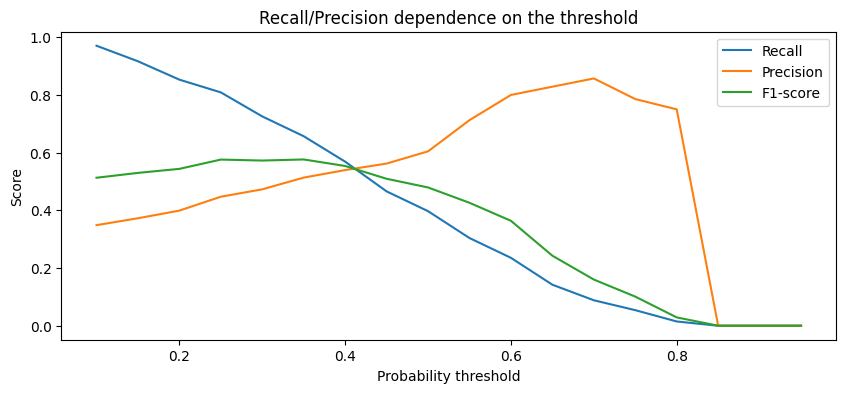

In [130]:
#Нас интересует только вероятность класса (второй столбец) - записываем предсказание вероятностей
y_test_proba_pred = log_reg.predict_proba(X_test_scaled)[:, 1]
#Для удобства завернем numpy-массив в pandas Series
y_test_proba_pred = pd.Series(y_test_proba_pred)
#Создадим списки, в которых будем хранить значения метрик 
recall_scores = []
precision_scores = []
f1_scores = []
#Сгенерируем набор вероятностных порогов в диапазоне от 0.1 до 1
thresholds = np.arange(0.1, 1, 0.05)
#В цикле будем перебирать сгенерированные пороги
for threshold in thresholds:
    #В противном случае - к классу 0
    y_test_pred = y_test_proba_pred.apply(lambda x: 1 if x>threshold else 0)
    #Считаем метрики и добавляем их в списки
    recall_scores.append(metrics.recall_score(y_test, y_test_pred))
    precision_scores.append(metrics.precision_score(y_test, y_test_pred))
    f1_scores.append(metrics.f1_score(y_test, y_test_pred))

#Визуализируем метрики при различных threshold
fig, ax = plt.subplots(figsize=(10, 4)) #фигура + координатная плоскость
#Строим линейный график зависимости recall от threshold
ax.plot(thresholds, recall_scores, label='Recall')
#Строим линейный график зависимости precision от threshold
ax.plot(thresholds, precision_scores, label='Precision')

#Строим линейный график зависимости F1 от threshold
ax.plot(thresholds, f1_scores, label='F1-score')
#Даем графику название и подписи осям
ax.set_title('Recall/Precision dependence on the threshold')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')
ax.legend();

In [131]:
#Задаем оптимальный порог вероятностей
threshold_opt = 0.4
y_test_pred_opt = y_test_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)
#Считаем метрики
print(metrics.classification_report(y_test, y_test_pred_opt))

              precision    recall  f1-score   support

           0       0.79      0.77      0.78       424
           1       0.54      0.57      0.55       204

    accuracy                           0.70       628
   macro avg       0.66      0.67      0.67       628
weighted avg       0.71      0.70      0.70       628



При смещения порога мы добились метрики F1 на тестовой выборке в 0.55, что удовлетворяет условию

### 5. Полиномиальная регрессия

- Сгенерируем полиномиальные признаки третьей степени для тренировочной и тестовой выборок. 
- Обучим модель логистической регрессии на полиномиальных признаках 
- Предскажем метки классов для тренировочной и тестовой выборок.
- Рассчитаем значение целевой метрики на тренировочной и тестовой выборках для модели, обученной на полиномиальных признаках.
- Сравним результат с полученным ранее

In [132]:
#Создаем объект для генерации полиномиальных признаков степени 2
poly = preprocessing.PolynomialFeatures(degree=3, include_bias=False)
#Вычисляем параметры генерации - результирующее количество признак
poly.fit(X_train_scaled)
#Производим преобразование для каждой из выборок
X_train_scaled_poly = poly.transform(X_train_scaled)
X_test_scaled_poly = poly.transform(X_test_scaled)

print('Train shape: {}'.format(X_train_scaled_poly.shape))
print('Test shape: {}'.format(X_test_scaled_poly.shape))

Train shape: (1881, 454)
Test shape: (628, 454)


In [142]:
lr_poly= linear_model.LogisticRegression(
    solver='sag', #алгоритм оптимизации стохастический градиентный спуск
    random_state=42, #генератор случайных чисел
    max_iter=1000, #количество итераций на сходимость
    penalty = 'l2',
    C = 2
)

#lr_poly = linear_model.LinearRegression()
lr_poly.fit(X_train_scaled_poly, y_train)
y_train_pred_poly = lr_poly.predict(X_train_scaled_poly)
y_test_pred_poly = lr_poly.predict(X_test_scaled_poly)

#Считаем метрики
print('Полниномиальная регрессия: ', '\n', metrics.classification_report(y_test, y_test_pred_poly))
print('Логистическая регрессия без полином.признаков: ', '\n', metrics.classification_report(y_test, y_test_pred_opt))

Полниномиальная регрессия:                precision    recall  f1-score   support

           0       0.82      0.90      0.86       424
           1       0.74      0.58      0.65       204

    accuracy                           0.80       628
   macro avg       0.78      0.74      0.75       628
weighted avg       0.79      0.80      0.79       628

Логистическая регрессия без полином.признаков:                precision    recall  f1-score   support

           0       0.79      0.77      0.78       424
           1       0.54      0.57      0.55       204

    accuracy                           0.70       628
   macro avg       0.66      0.67      0.67       628
weighted avg       0.71      0.70      0.70       628



У полиномиальной результат F1 значительно выше - на уровне 0.65, чего не удалось добиться до этого

Попробуем подобрать значение порога вероятности, при котором наблюдается наибольшее значение целевой метрики на тестовой выборке. В качестве модели используем логистическую регрессию, обученную на полиномиальных признаках. 

В качестве порога вероятности используем значения из следующего диапазона:

`thresholds = np.arange(0.1, 1, 0.05)`


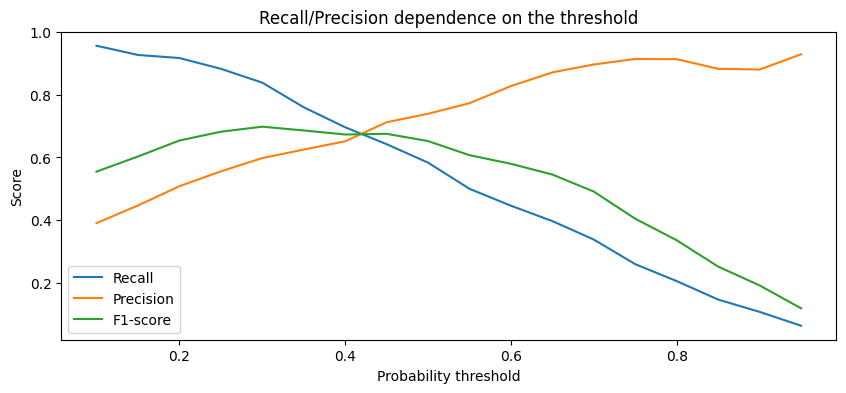

In [144]:
#Нас интересует только вероятность класса (второй столбец) - записываем предсказание вероятностей
y_test_proba_pred = lr_poly.predict_proba(X_test_scaled_poly)[:, 1]
#Для удобства завернем numpy-массив в pandas Series
y_test_proba_pred = pd.Series(y_test_proba_pred)
#Создадим списки, в которых будем хранить значения метрик 
recall_scores = []
precision_scores = []
f1_scores = []
#Сгенерируем набор вероятностных порогов в диапазоне от 0.1 до 1
thresholds = np.arange(0.1, 1, 0.05)
#В цикле будем перебирать сгенерированные пороги
for threshold in thresholds:
    #В противном случае - к классу 0
    y_test_pred = y_test_proba_pred.apply(lambda x: 1 if x>threshold else 0)
    #Считаем метрики и добавляем их в списки
    recall_scores.append(metrics.recall_score(y_test, y_test_pred))
    precision_scores.append(metrics.precision_score(y_test, y_test_pred))
    f1_scores.append(metrics.f1_score(y_test, y_test_pred))

#Визуализируем метрики при различных threshold
fig, ax = plt.subplots(figsize=(10, 4)) #фигура + координатная плоскость
#Строим линейный график зависимости recall от threshold
ax.plot(thresholds, recall_scores, label='Recall')
#Строим линейный график зависимости precision от threshold
ax.plot(thresholds, precision_scores, label='Precision')

#Строим линейный график зависимости F1 от threshold
ax.plot(thresholds, f1_scores, label='F1-score')
#Даем графику название и подписи осям
ax.set_title('Recall/Precision dependence on the threshold')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')
ax.legend();

In [146]:
#Задаем оптимальный порог вероятностей
threshold_opt = 0.3
y_test_pred_opt = y_test_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)
#Считаем метрики
print(metrics.classification_report(y_test, y_test_pred_opt))

              precision    recall  f1-score   support

           0       0.90      0.73      0.81       424
           1       0.60      0.84      0.70       204

    accuracy                           0.76       628
   macro avg       0.75      0.78      0.75       628
weighted avg       0.80      0.76      0.77       628



Финально удалось поднять метрику при пороге 0.4 (т.е. точке пересечения) до 0.67, а при пороге 0.3 (т.е. максимум F1) до 0.7

### 6. Деревья решений и случайный лес

Мы продолжаем решать задачу прогнозирования оттока клиентов банка.

Теперь попробуем решить задачу с помощью деревьев решений и лесов. По аналогии с предыдущими моделями

- Обучим на тренировочной выборке дерево решений из библиотеки с неограниченной максимальной глубиной дерева. 
- Сделаем предсказания для тренировочной и тестовой выборок. 
- Воспользуемся регуляризацией в случае переобчуения

In [148]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X, y, 
    stratify=y, 
    random_state=0
)
print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape))

Train shape: (1881, 12)
Test shape: (628, 12)


Импортируем необходимые для выполнения практики модули:

In [149]:
from sklearn import tree
from sklearn import ensemble

In [157]:
# Ваш код здесь

#Создаём объект класса DecisionTreeClassifier
dt_clf = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности 
    #max_depth=3, #максимальная глубина
    random_state=42 #генератор случайных чисел
)
#Обучаем дерево решений по алгоритму CART
dt_clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', random_state=42)

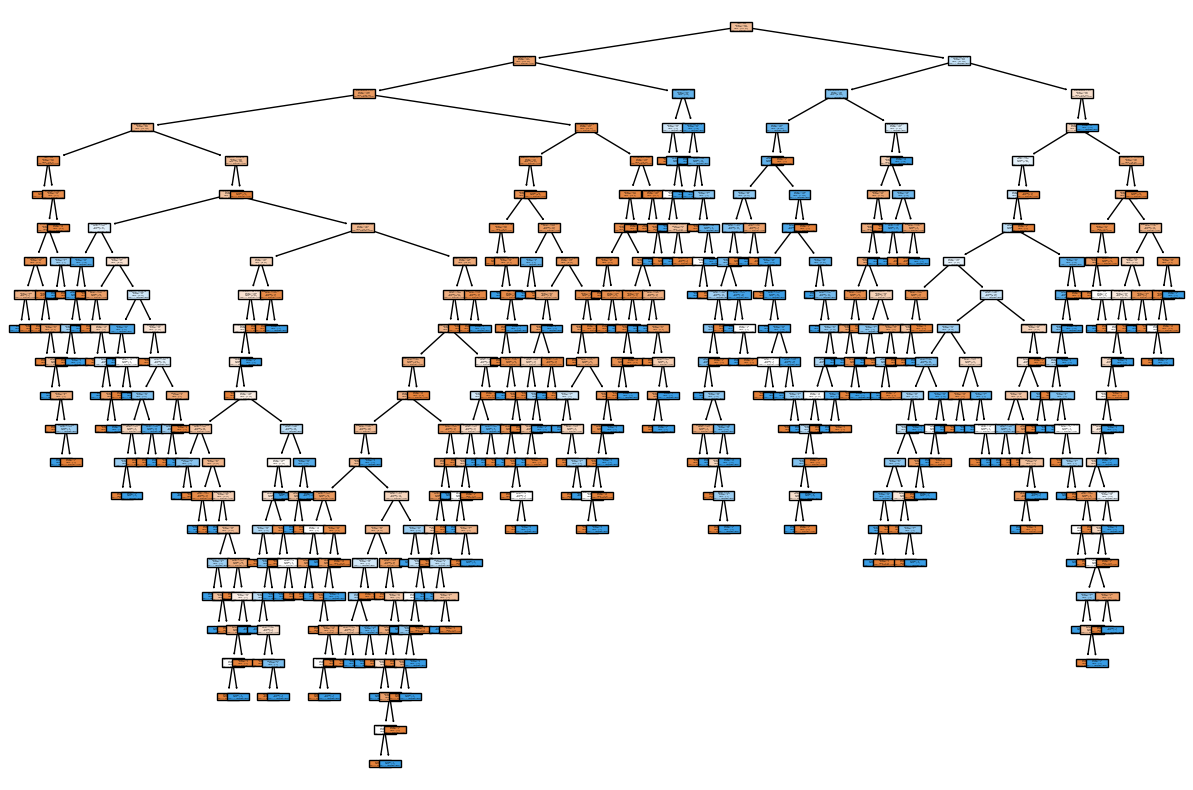

In [152]:
#Создаём фигуру для визуализации графа
fig = plt.figure(figsize=(15, 10))
#Строим граф дерева решений
tree.plot_tree(
    dt_clf, #объект обученного дерева
    feature_names=X.columns, #наименования факторов
    class_names=["0 - Лояльный клиент", "1 - Ушедший клиент"], #имена классов
    filled=True, #расцветка графа
);

In [153]:
dt_clf.get_depth()

22

In [155]:
#Делаем предсказание класса для всего набора данных
y_pred_train = dt_clf.predict(X_train)
y_pred_test = dt_clf.predict(X_test)
#Выводим отчёт о метриках классификации
print('Тренинговые данные: ',  '\n', metrics.classification_report(y_train, y_pred_train))
print('Тестовые данные: ',  '\n', metrics.classification_report(y_test, y_pred_test))

Тренинговые данные:  
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1271
           1       1.00      1.00      1.00       610

    accuracy                           1.00      1881
   macro avg       1.00      1.00      1.00      1881
weighted avg       1.00      1.00      1.00      1881

Тестовые данные:  
               precision    recall  f1-score   support

           0       0.79      0.80      0.79       424
           1       0.57      0.55      0.56       204

    accuracy                           0.72       628
   macro avg       0.68      0.68      0.68       628
weighted avg       0.72      0.72      0.72       628



На лицо переобученная модель - 22 - огромная глубина, идеальное выделение на тренинговой выборке и невысокое на тестовой


Давайте «подстрижём» наше дерево. 


In [158]:

#Создаём объект класса DecisionTreeClassifier
dt_clf_8 = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий информативности 
    max_depth=8, #максимальная глубина
    random_state=42 #генератор случайных чисел
)
#Обучаем дерево решений по алгоритму CART
dt_clf_8.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=8, random_state=42)

In [159]:
#Делаем предсказание класса для всего набора данных
y_pred_train = dt_clf_8.predict(X_train)
y_pred_test = dt_clf_8.predict(X_test)
#Выводим отчёт о метриках классификации
print('Тренинговые данные: ',  '\n', metrics.classification_report(y_train, y_pred_train))
print('Тестовые данные: ',  '\n', metrics.classification_report(y_test, y_pred_test))

Тренинговые данные:  
               precision    recall  f1-score   support

           0       0.86      0.93      0.89      1271
           1       0.82      0.69      0.75       610

    accuracy                           0.85      1881
   macro avg       0.84      0.81      0.82      1881
weighted avg       0.85      0.85      0.85      1881

Тестовые данные:  
               precision    recall  f1-score   support

           0       0.81      0.87      0.84       424
           1       0.68      0.59      0.63       204

    accuracy                           0.78       628
   macro avg       0.75      0.73      0.74       628
weighted avg       0.77      0.78      0.77       628



Метрики стали сильно лучше, переобучения нет, но пока вссе еще лучшие результаты были у полиномиальной модели

Давайте воспользуемся случайным лесом. 


In [160]:
# Ваш код здесь

#Создаём объект класса RandomForestClassifier
rf_clf = ensemble.RandomForestClassifier(
    n_estimators=500, #число деревьев
    criterion='entropy', #критерий эффективности
    max_depth=8, #максимальная глубина дерева
    min_samples_leaf=10, # количество наблюдений в листе
    random_state=42 #генератор случайных чисел
)
#Обучаем модель 
rf_clf.fit(X_train, y_train)


RandomForestClassifier(criterion='entropy', max_depth=8, min_samples_leaf=10,
                       n_estimators=500, random_state=42)

In [161]:
#Делаем предсказание класса для всего набора данных
y_pred_train = rf_clf.predict(X_train)
y_pred_test = rf_clf.predict(X_test)
#Выводим отчёт о метриках классификации
print('Тренинговые данные: ',  '\n', metrics.classification_report(y_train, y_pred_train))
print('Тестовые данные: ',  '\n', metrics.classification_report(y_test, y_pred_test))

Тренинговые данные:  
               precision    recall  f1-score   support

           0       0.85      0.95      0.89      1271
           1       0.85      0.65      0.74       610

    accuracy                           0.85      1881
   macro avg       0.85      0.80      0.81      1881
weighted avg       0.85      0.85      0.84      1881

Тестовые данные:  
               precision    recall  f1-score   support

           0       0.82      0.91      0.86       424
           1       0.75      0.58      0.66       204

    accuracy                           0.80       628
   macro avg       0.78      0.74      0.76       628
weighted avg       0.80      0.80      0.79       628



Результаты стали немного лучше, но полиномиальная модель пока еще превосходит по всем метрикам тестовой выборки

Попробуем подобрать значение порога вероятности, при котором наблюдается наибольшее значение целевой метрики на тестовой выборке.

C:\Users\Lyudmila\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Lyudmila\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


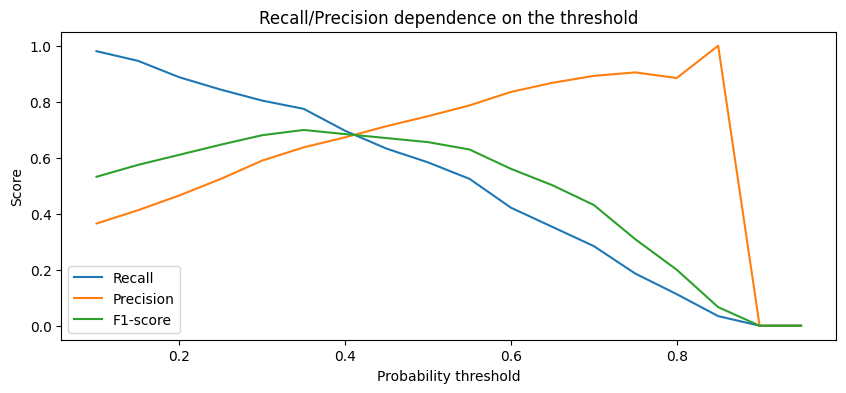

In [162]:
#Нас интересует только вероятность класса (второй столбец) - записываем предсказание вероятностей
y_test_proba_pred = rf_clf.predict_proba(X_test)[:, 1]
#Для удобства завернем numpy-массив в pandas Series
y_test_proba_pred = pd.Series(y_test_proba_pred)
#Создадим списки, в которых будем хранить значения метрик 
recall_scores = []
precision_scores = []
f1_scores = []
#Сгенерируем набор вероятностных порогов в диапазоне от 0.1 до 1
thresholds = np.arange(0.1, 1, 0.05)
#В цикле будем перебирать сгенерированные пороги
for threshold in thresholds:
    #В противном случае - к классу 0
    y_test_pred = y_test_proba_pred.apply(lambda x: 1 if x>threshold else 0)
    #Считаем метрики и добавляем их в списки
    recall_scores.append(metrics.recall_score(y_test, y_test_pred))
    precision_scores.append(metrics.precision_score(y_test, y_test_pred))
    f1_scores.append(metrics.f1_score(y_test, y_test_pred))

#Визуализируем метрики при различных threshold
fig, ax = plt.subplots(figsize=(10, 4)) #фигура + координатная плоскость
#Строим линейный график зависимости recall от threshold
ax.plot(thresholds, recall_scores, label='Recall')
#Строим линейный график зависимости precision от threshold
ax.plot(thresholds, precision_scores, label='Precision')

#Строим линейный график зависимости F1 от threshold
ax.plot(thresholds, f1_scores, label='F1-score')
#Даем графику название и подписи осям
ax.set_title('Recall/Precision dependence on the threshold')
ax.set_xlabel('Probability threshold')
ax.set_ylabel('Score')
ax.legend();

In [165]:
#Задаем оптимальный порог вероятностей
threshold_opt = 0.37

y_test_pred_opt = y_test_proba_pred.apply(lambda x: 1 if x > threshold_opt else 0)
#Считаем метрики
print(metrics.classification_report(y_test, y_test_pred_opt))

              precision    recall  f1-score   support

           0       0.87      0.81      0.84       424
           1       0.65      0.75      0.70       204

    accuracy                           0.79       628
   macro avg       0.76      0.78      0.77       628
weighted avg       0.80      0.79      0.79       628



При подходящем пороговом значении удалось добиться такой же метрики 0.7 для F1, как и в полиномиальной регрессии. Показатель precision стал чуть выше (в полин - 0.6), а recall ниже (в полин - 0.84). Они стали чуть ближе, что лучше для модели: более высокий Precision говорит о том, что у нас меньше вероятность модели допустить ошибку I рода, т.е. записать в ушедших лояльных клиентов. Небольшое снижение recall говорит о том, что вероятность модели допустить ошибку II рода стала выше, т.е. не "отловить" клиентов, которые планируют уйти из банка и ошибочно занести их к лояльным. Однако показатель метрики все еще достаточно велик.